# Section 4 - Avoiding data overinterpretation

* One common source of data overinterpretation is a failure to correct for multiple hypothesis testing
* When we use the same set of data to test a set of hypotheses we need to correct for **false discovery rate**
* **False discovery rate** (FDR) is a statistical measure used to estimate the proportion of false positives within a set of hypothesis tests
* When performing many hypothesis tests on the same data (*e.g.*, when creating many different contingency tables from the same set of data and running Fisher's Exact Test on each of them) it is best practice to correct *p*-values for FDR

## Example 4.1
**Application 4.1**: We hypothesize that entangled proteins are not randomly distributed within biological pathways in humans

* Many biological pathways exist in humans (**Figure 4.1**), meaning that testing the hypothesis in **Application 4.1** actually requires many different hypothesis tests

![](../images/reactome-pathway-subset.png)

**Figure 4.1** *A subset of the biological pathways identified for humans in the Reactome database. Nodes represent individual processes/reactions, e.g. "WNT5A-dependent internalization of FZD4", and edges represent interactions between processes. Image from https://reactome.org/PathwayBrowser/*

* For each pathway in humans, we need to construct a contingency table and compute the odds ratio as well as the *p*-value
* For the sake of simplicity, we will omit the initial calculation of {a, b, c, d}, odds ratios, and *p*-values to focus on correcting the *p*-values for **FDR**

### Step 0 - Load libraries

In [1]:
import pandas as pd
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

### Step 1 - Load the data

In [2]:
# list of columns to use from the dataset
column_list = ["unique_pathways", "a_in_pathway_entangled",	"b_out_pathway_entangled",
               "c_in_pathway_not_entangled", "d_out_pathway_not_entangled",	"odds_ratios", "two_sided_p_values"]

# load the specified columns; "data9" is a pandas DataFrame object
data_path = "/home/jovyan/data-store/data/iplant/home/shared/NCEMS/BPS-training-2025/"
data9     = pd.read_csv(data_path + "pathways-and-entangled-proteins.csv", usecols = column_list)

### Step 2 - Explore the data

In [3]:
# print a quick summary of "data9"
data9.info()

# print the first 10 rows of "data9"
data9.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2150 entries, 0 to 2149
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   unique_pathways              2150 non-null   object 
 1   a_in_pathway_entangled       2150 non-null   int64  
 2   b_out_pathway_entangled      2150 non-null   int64  
 3   c_in_pathway_not_entangled   2150 non-null   int64  
 4   d_out_pathway_not_entangled  2150 non-null   int64  
 5   odds_ratios                  2150 non-null   float64
 6   two_sided_p_values           2150 non-null   float64
dtypes: float64(2), int64(4), object(1)
memory usage: 117.7+ KB


,unique_pathways,a_in_pathway_entangled,b_out_pathway_entangled,c_in_pathway_not_entangled,d_out_pathway_not_entangled,odds_ratios,two_sided_p_values
0,R-HSA-166663,38,11517,41,8908,0.716891,0.141226
1,R-HSA-173623,33,11522,37,8912,0.689880,0.146931
2,R-HSA-198933,100,11455,97,8852,0.796677,0.112900
3,R-HSA-202733,66,11489,85,8864,0.599089,0.002205
4,R-HSA-2029481,34,11521,40,8909,0.657315,0.078217
5,R-HSA-2029482,77,11478,46,8903,1.298366,0.171969
6,R-HSA-2029485,45,11510,43,8906,0.809763,0.333862
7,R-HSA-2168880,35,11520,39,8910,0.694132,0.127166
8,R-HSA-2454202,29,11526,37,8912,0.606054,0.046602
9,R-HSA-2730905,37,11518,38,8911,0.753317,0.243788


* Each row of this DataFrame corresponds to a unique Reactome pathway
* The columns correspond to:
    * `unique_pathways`: The pathway identifier
    * `a_in_pathway_entangled`: Number of proteins in the pathway that are entangled (a in contingency table)
    * `b_out_pathway_entangled`: Number of proteins *not* in the pathway that are entangled (b in contingency table)
    * `c_in_pathway_not_entangled`: Number of proteins in the pathway that are *not* entangled (c in contingency table)
    * `d_out_pathway_not_entangled`: Number of proteins *not* in the pathway that are *not* entangled (d in contingency table)
    * `odds_ratios`: The odds ratio calculated from a 2x2 contingency table (see below)
    * `two_sided_p_values`: Initial uncorrected *p*-value from Fisher's Exact Test
* The contingency tables used in this analysis had the following form:

This is our contingency table:



<Figure size 640x480 with 0 Axes>

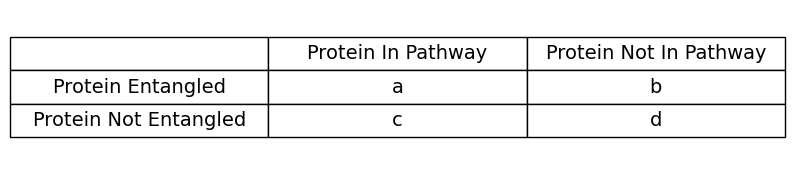

In [4]:
# put values into a new format to enable a nice print statement & analysis
contingency_table = pd.DataFrame({"Protein In Pathway"    : ['a', 'c'], 
                                  "Protein Not In Pathway": ['b', 'd']},
                                 index = ["Protein Entangled", "Protein Not Entangled"])

# print the output
print ("This is our contingency table:\n")

# create a table from our contingency_table using matplotlib
plt.clf()
fig, ax    = plt.subplots(figsize = (5, 2))
ax.axis("tight")
ax.axis("off")
cell_text  = contingency_table.reset_index().values.tolist()
col_labels = [""] + contingency_table.columns.tolist()
table      = ax.table(cellText=cell_text, colLabels=col_labels, loc="center", cellLoc="center")
table.auto_set_font_size(False)
table.set_fontsize(14)  
table.scale(2, 2)  
plt.show()

### Step 3 - Run the analysis
* With the data loaded, we are ready to correct our *p*-values and interpret the results

Using the uncorrected p-values, we would conclude 539 pathways have a non-random number of entangled proteins

Using the corrected p-values, we conclude 318 pathways have a non-random number of entangled proteins



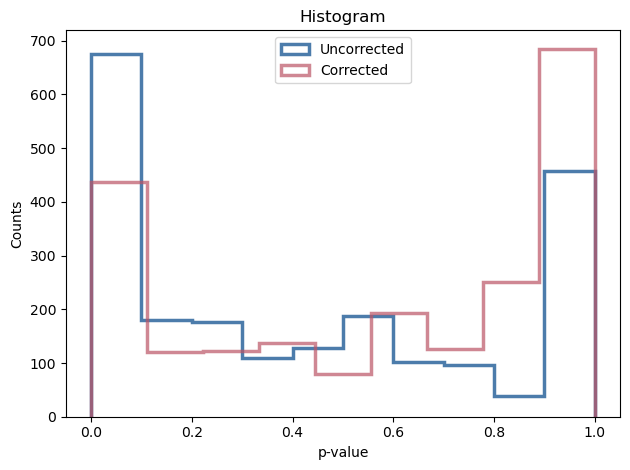

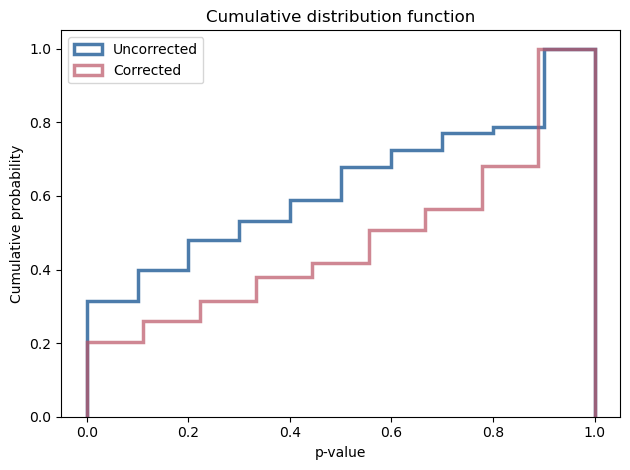

In [5]:
# define the significance level for our tests
alpha = 0.05

# apply the Benjamini-Hochberg procedure for FDR correction
_, pvals_corrected, _, _ = multipletests(data9['two_sided_p_values'], alpha = alpha, method = 'fdr_bh')

# add corrected p-values as a new column
data9['two_sided_p_values-adjusted'] = pvals_corrected

# compute the proportions of uncorrected & corrected p-values < alpha
N_uncorr_acc = ((data9["two_sided_p_values"]          < alpha) & (data9["odds_ratios"] != 1.0)).sum()
N_corr_acc   = ((data9["two_sided_p_values-adjusted"] < alpha) & (data9["odds_ratios"] != 1.0)).sum()

print ("Using the uncorrected p-values, we would conclude", N_uncorr_acc, "pathways have a non-random number of entangled proteins\n")
print ("Using the corrected p-values, we conclude", N_corr_acc, "pathways have a non-random number of entangled proteins\n")

# make a plot of the distributions of p-values before & after the FDR correction
plt.clf()
plt.title("Histogram")
plt.hist(data9["two_sided_p_values"], color = "#004488", alpha = 0.7, label = "Uncorrected", histtype = "step", bins = "fd", linewidth=2.5) # here, alpha != significance level
plt.hist(data9["two_sided_p_values-adjusted"], color = "#BB5566", alpha = 0.7, label = "Corrected", histtype = "step", bins = "fd", linewidth=2.5)
plt.xlabel("p-value")
plt.ylabel("Counts")
plt.legend(loc = "best")
plt.tight_layout()
plt.show()

# it can be easier to see differences when considering the cumulative distribution function
plt.clf()
plt.title("Cumulative distribution function")
plt.hist(data9["two_sided_p_values"], color = "#004488", alpha = 0.7, label = "Uncorrected", histtype = "step", bins = "fd", density = True, cumulative = True, linewidth=2.5) # here, alpha != significance level
plt.hist(data9["two_sided_p_values-adjusted"], color = "#BB5566", alpha = 0.7, label = "Corrected", histtype = "step", bins = "fd", density = True, cumulative = True, linewidth=2.5)
plt.xlabel("p-value")
plt.ylabel("Cumulative probability")
plt.legend(loc = "best")
plt.tight_layout()
plt.show()

### Step 4 - Interpret the results

* We conclude that 318 pathways contain a non-random number of entangled proteins
    * We have eliminated 539 - 318 = 221 false positives
* The Benjamini-Hochberg procedure does not eliminate the presence of false positives; with our threshold of 0.05, we have reduced the false discovery rate to 5% or less
* Associations that are significant before the Benjamini-Hochberg correction and not significant afterwards likely arise from random chance